
* Figure 7: Load all maps and the footprint and make bias plots with the zpt correction / error correction
* Figure 8: Noise vs Latitude plot
* Figure 9: Visual Comparisons

In [1]:
import pickle
import sys
import numpy as np
import healpy as hp

from sys import platform
if platform=='linux':
    sys.path.append('/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/methods_code_Nresol/')
    sys.path.append('/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/utils/')
else:
    sys.path.append('../methods_code_Nresol/')

import vis_utils
import utils_circpatch
from utils_circpatch import *
from do_recon_tilewise import *
from vis_utils import *
from testbeds import *

In [2]:
nbmaindir = '../notebooks_main1/'

## Paper Plots Start Here

In [3]:
sfdmap = vis_utils.get_sfd_map()
b17map, b17sigmamap = get_bayestar2017_map(return_sigma=True)
fskdir = '../notebooks_main1/fullsky_runs/'

fits61 = hp.fitsfunc.read_map(fskdir+'fits_outputs/recon_fw6-1_final_mult.fits', field=None, h=True)
fits15 = hp.fitsfunc.read_map(fskdir+'fits_outputs/recon_fw15_final_mult.fits', field=None, h=True)

reconzpt61, var61_corr = fits61[0][1], fits61[0][3]
reconzpt15, var15_corr = fits15[0][1], fits15[0][3]

Multiplying by the blue tip correction factor of 0.86
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)


In [4]:
sigmafw61 = np.sqrt(var61_corr)
sigmafw15 = np.sqrt(var15_corr)

<ipython-input-4-0cc3fc3aac83>:1: RuntimeWarning: invalid value encountered in sqrt
  sigmafw61 = np.sqrt(var61_corr)
<ipython-input-4-0cc3fc3aac83>:2: RuntimeWarning: invalid value encountered in sqrt
  sigmafw15 = np.sqrt(var15_corr)


In [5]:
(reconzpt61!=hp.UNSEEN).sum()/len(reconzpt61)

0.5193347732226054

In [6]:
fptpixels = np.arange(hp.nside2npix(2048))
fptpixels = fptpixels[reconzpt61!=hp.UNSEEN]

In [7]:
np.percentile(sfdmap[fptpixels], 2), np.percentile(sfdmap[fptpixels], 98)

(0.008756347447633744, 0.27846113681793194)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.] 50
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.] 50
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.] 50


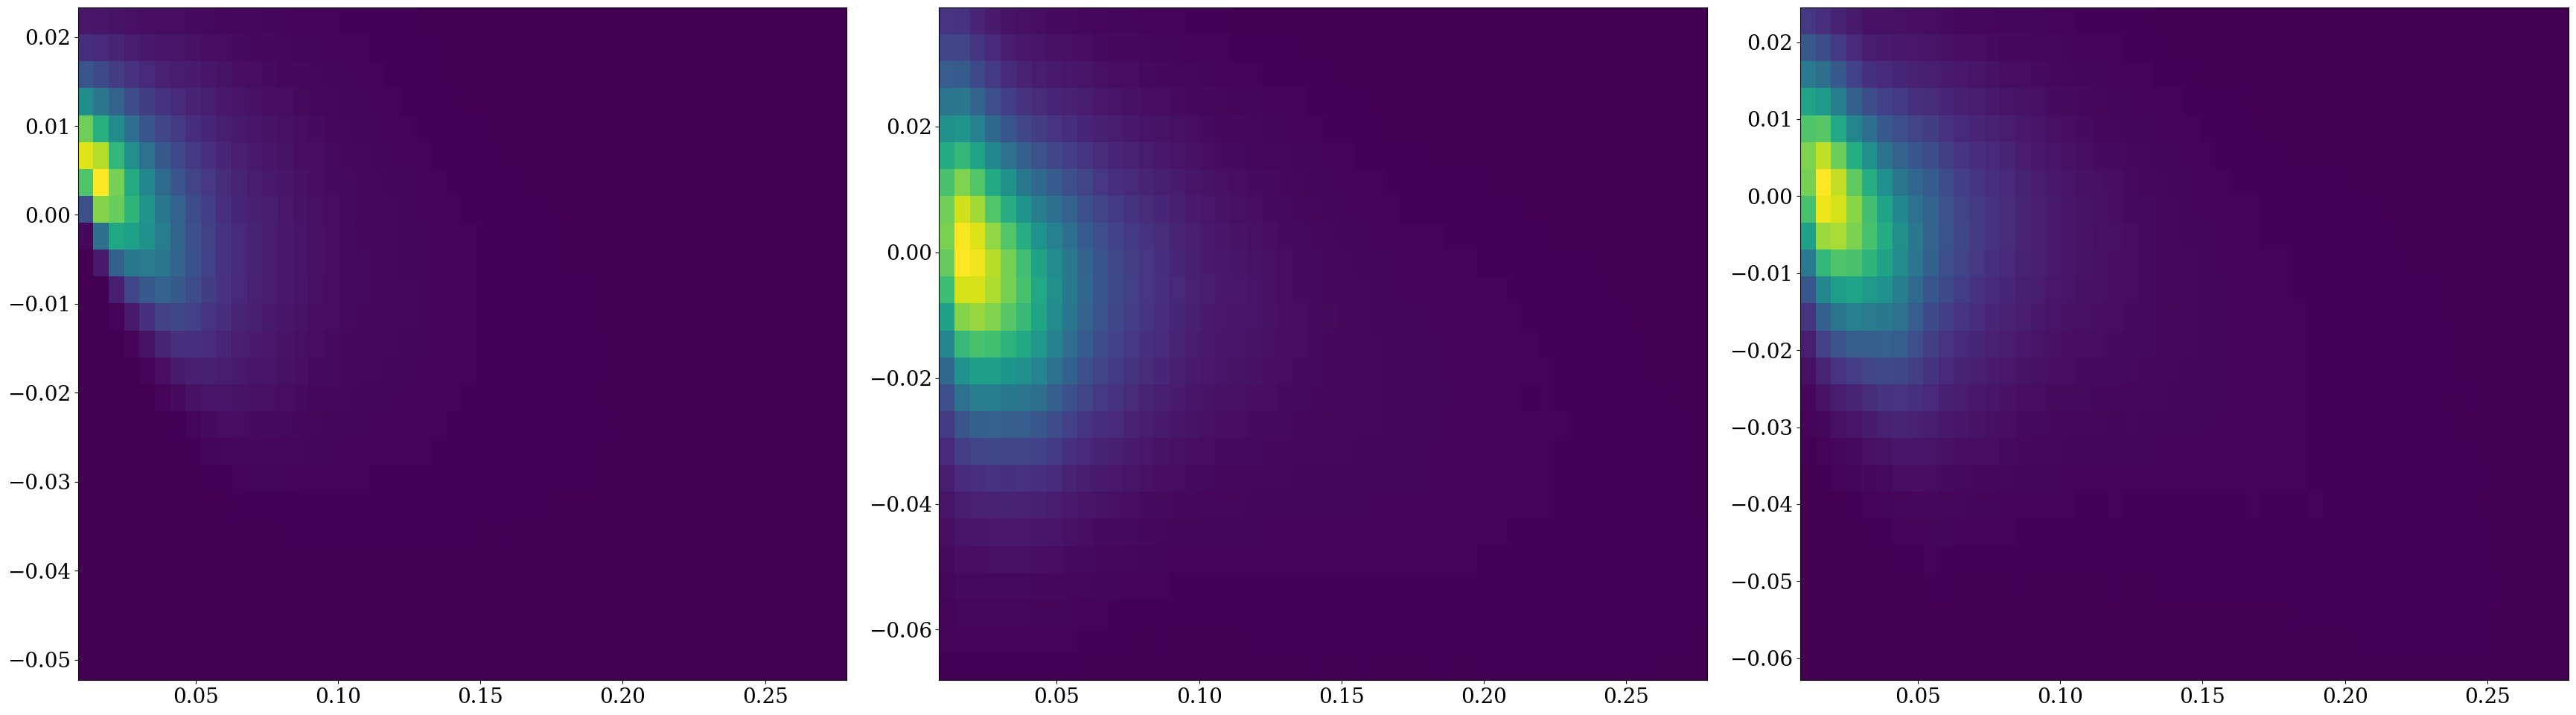

In [17]:
plt.rcParams.update({'font.family':'serif', 'font.size': 20})
fig, ax = plt.subplots(figsize=(35, 10), ncols=3)
sfdvals = sfdmap[fptpixels]
bias = reconzpt61[fptpixels] - sfdvals
b17bias = b17map[fptpixels] - sfdvals
bias15 = reconzpt15[fptpixels] - sfdvals

histmaps = []
xedg, yedg, bs = [], [], []
Nbinx, Nbiny = 50, 25
for i, rmap in enumerate([b17bias, bias, bias15]):
    extent = [[np.percentile(sfdmap[fptpixels], 2), np.percentile(sfdmap[fptpixels], 98)], [np.percentile(rmap, 2), np.percentile(rmap, 98)]]
    H, xe, ye, be = ax[i].hist2d(sfdvals, rmap, bins=[Nbinx, Nbiny], density=True, range=extent) #50 x bins, 10 ybins
    H = H/H.sum(axis=1).reshape((-1, 1))
    histmaps.append(H)
    xedg.append(xe)
    yedg.append(ye)
    bs.append(be)
    print(H.sum(axis=1), len(H.sum(axis=1)))
plt.show()

In [18]:
len(xedg[0]), len(yedg[0])

(51, 26)

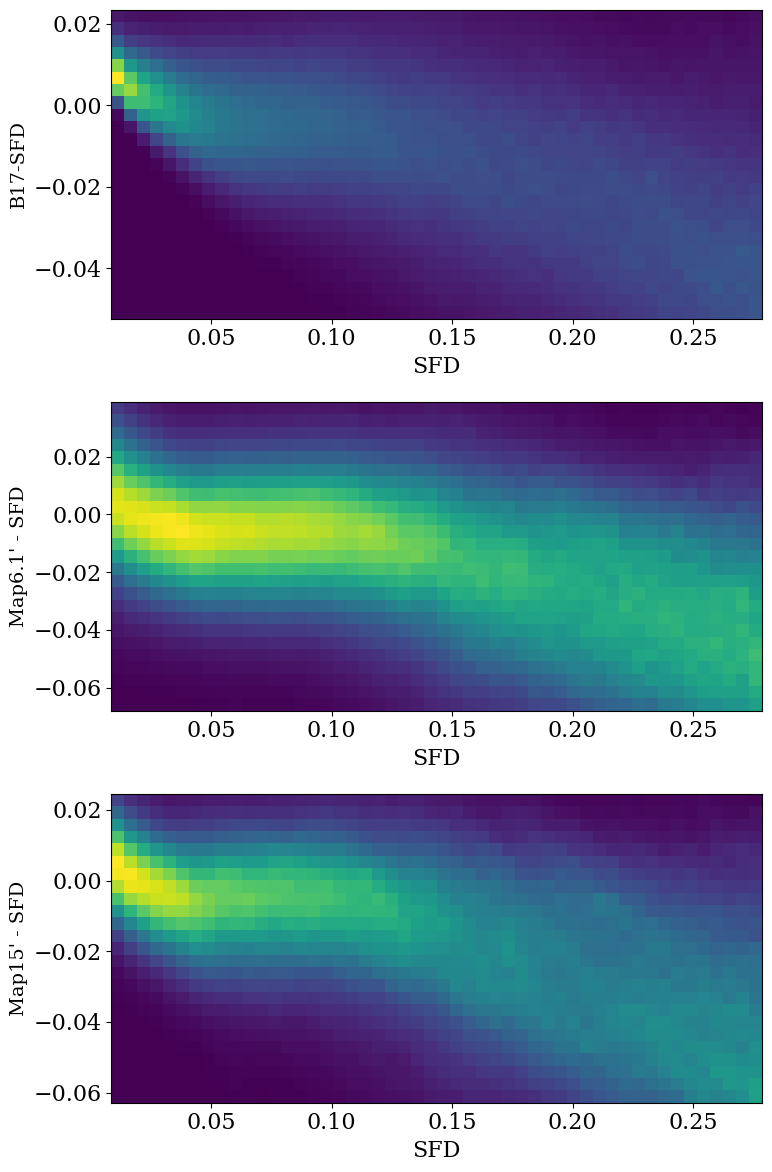

In [19]:
plt.rcParams.update({'figure.autolayout': True, 'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 12), nrows=3)
labelsx = np.linspace(0, Nbinx-1, 8, dtype=int)
labelsy = np.linspace(0, Nbiny-1, 8, dtype=int)
for i, hmap in enumerate(histmaps):
    ax[i].pcolormesh(xedg[i], yedg[i],hmap.T, shading='flat', rasterized=True)
plt.setp(ax, xlabel='SFD')
ax[0].set_ylabel('B17-SFD', fontsize=14)
ax[1].set_ylabel('Map6.1\' - SFD', fontsize=14)
ax[2].set_ylabel('Map15\' - SFD', fontsize=14)
plt.savefig('../plots/vs_extinction/11-17_biashogg_zptcorr_sigmacorr_raster.pdf', dpi=100)
plt.show()

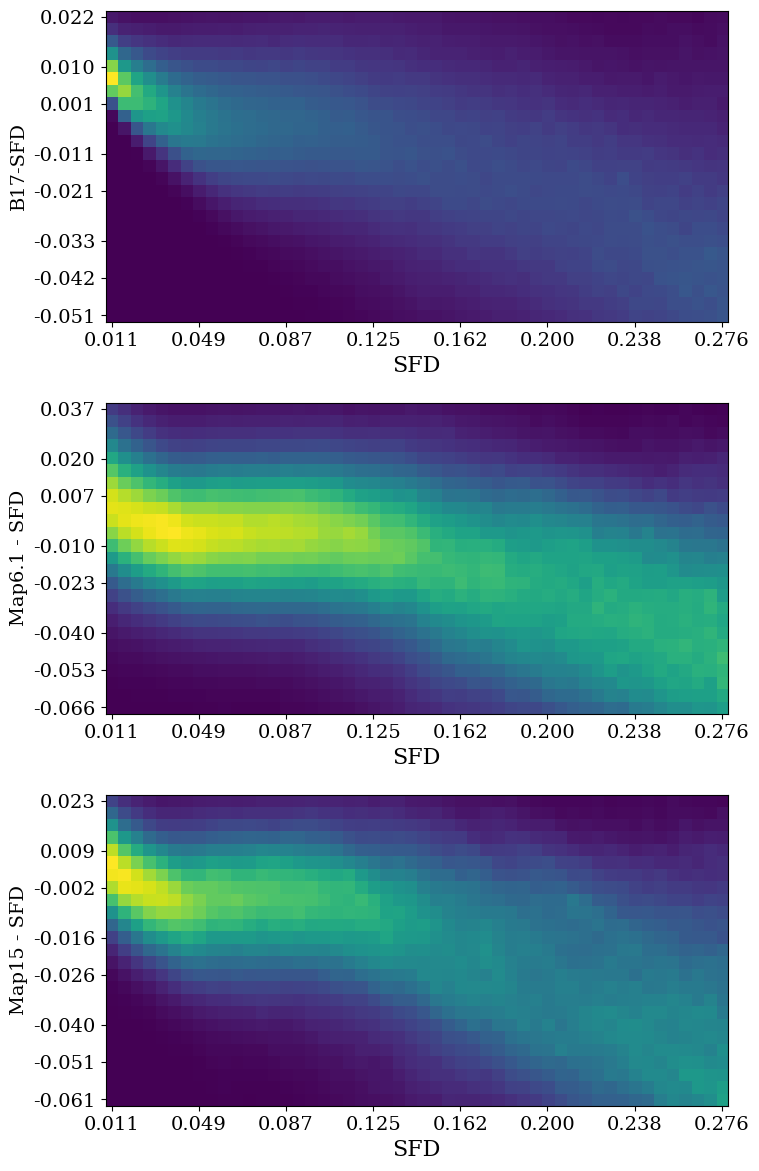

In [20]:
plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots(figsize=(8, 12), nrows=3)
labelsx = np.linspace(0, Nbinx-1, 8, dtype=int)
labelsy = np.linspace(0, Nbiny-1, 8, dtype=int)
for i, hmap in enumerate(histmaps):
    ax[i].imshow(hmap.T, origin='lower')
    xt = (xedg[i][1:] + xedg[i][:-1])/2 
    yt = (yedg[i][1:] + yedg[i][:-1])/2 
    ax[i].set_xticks(labelsx, ['{:.3f}'.format(x) for x in xt[labelsx]], fontsize=14)
    ax[i].set_yticks(labelsy, ['{:.3f}'.format(x) for x in yt[labelsy]], fontsize=14)
plt.setp(ax, xlabel='SFD')
ax[0].set_ylabel('B17-SFD', fontsize=14)
ax[1].set_ylabel('Map6.1 - SFD', fontsize=14)
ax[2].set_ylabel('Map15 - SFD', fontsize=14)
#plt.savefig('../plots/vs_extinction/11-10_biashogg_zptcorr_sigmacorr.pdf', dpi=100)
plt.show()

In [21]:
histmaps[i].shape #histmaps[0][i, j]: #i: 0->49, j: 0->24

(50, 25)

#### Z Score

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


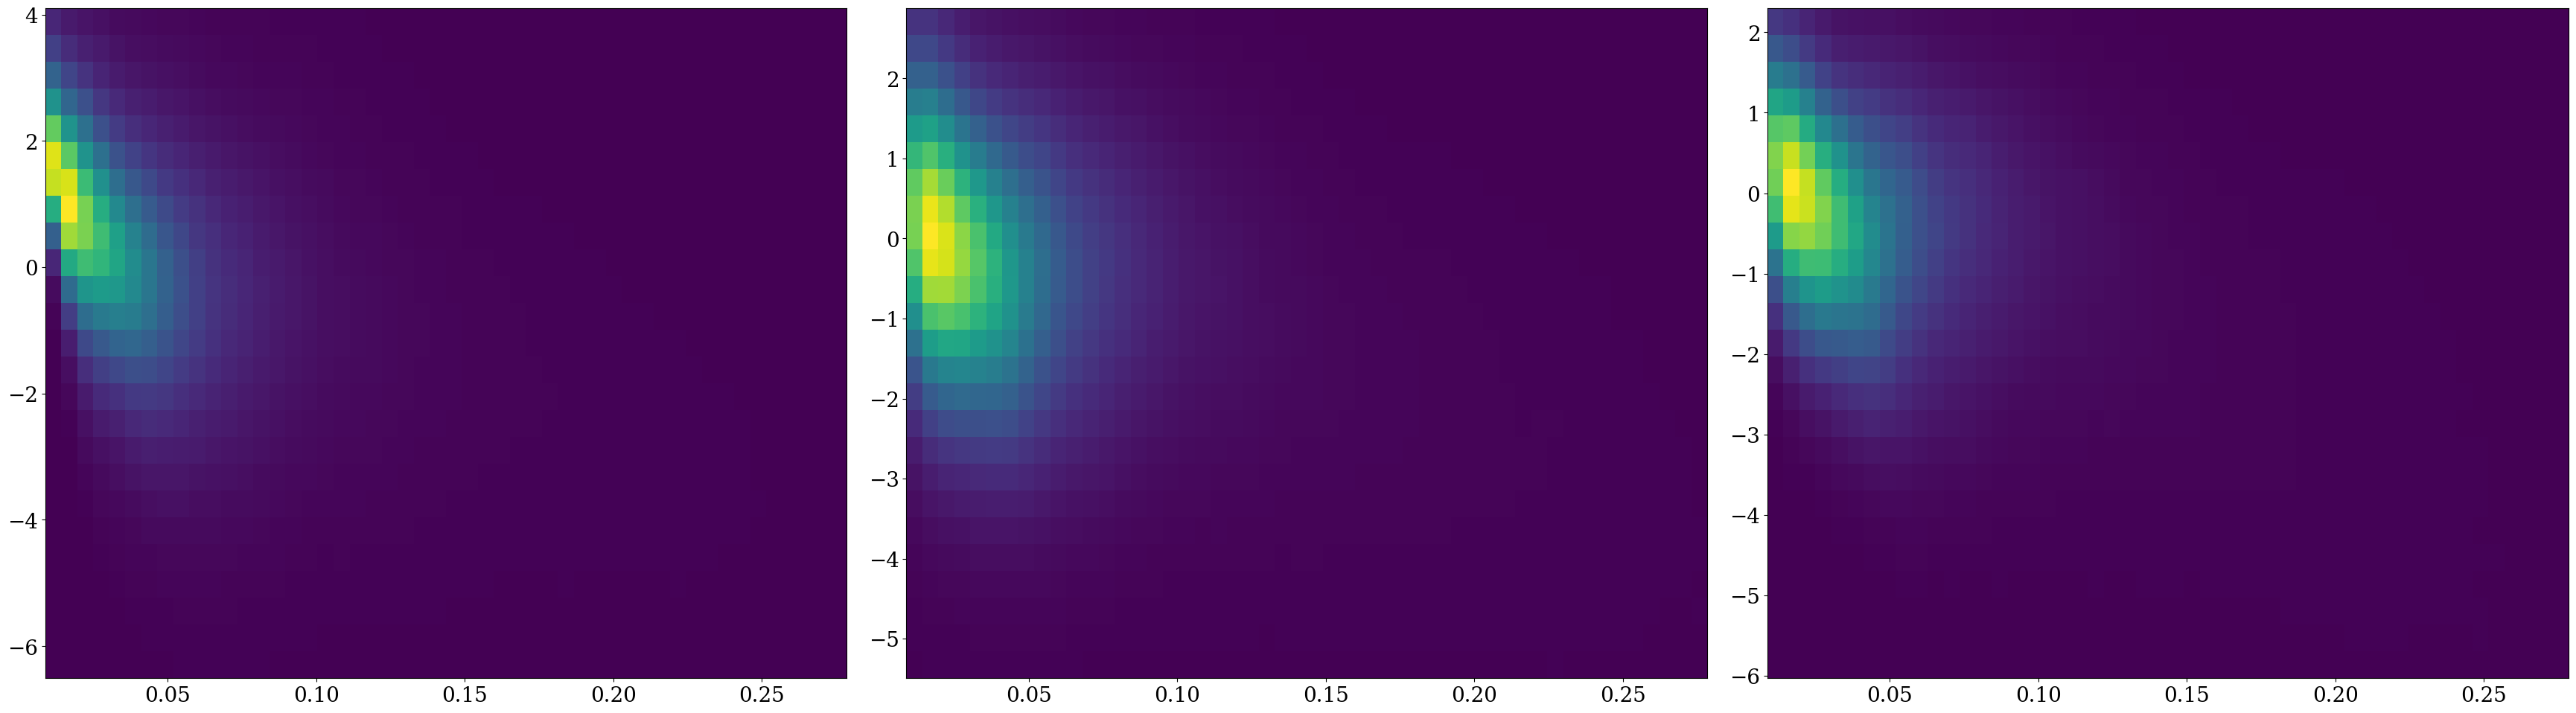

In [22]:
plt.rcParams.update({'font.family':'serif', 'font.size': 20})
fig, ax = plt.subplots(figsize=(35, 10), ncols=3)
sfdvals = sfdmap[fptpixels]
b17bias = (b17map[fptpixels] - sfdvals)/b17sigmamap[fptpixels]
bias = (reconzpt61[fptpixels] - sfdvals)/sigmafw61[fptpixels]
bias15 = (reconzpt15[fptpixels] - sfdvals)/sigmafw15[fptpixels]

histmaps = []
xedg, yedg, bs = [], [], []
Nbinx, Nbiny = 50, 25
for i, rmap in enumerate([b17bias, bias, bias15]):
    extent = [[np.percentile(sfdmap[fptpixels], 2), np.percentile(sfdmap[fptpixels], 98)], [np.percentile(rmap, 2), np.percentile(rmap, 98)]]
    H, xe, ye, be = ax[i].hist2d(sfdvals, rmap, bins=[Nbinx, Nbiny], density=True, range=extent) #50 x bins, 10 ybins
    H = H/H.sum(axis=1).reshape((-1, 1))
    histmaps.append(H)
    xedg.append(xe)
    yedg.append(ye)
    bs.append(be)
    print(H.sum(axis=1))
plt.show()

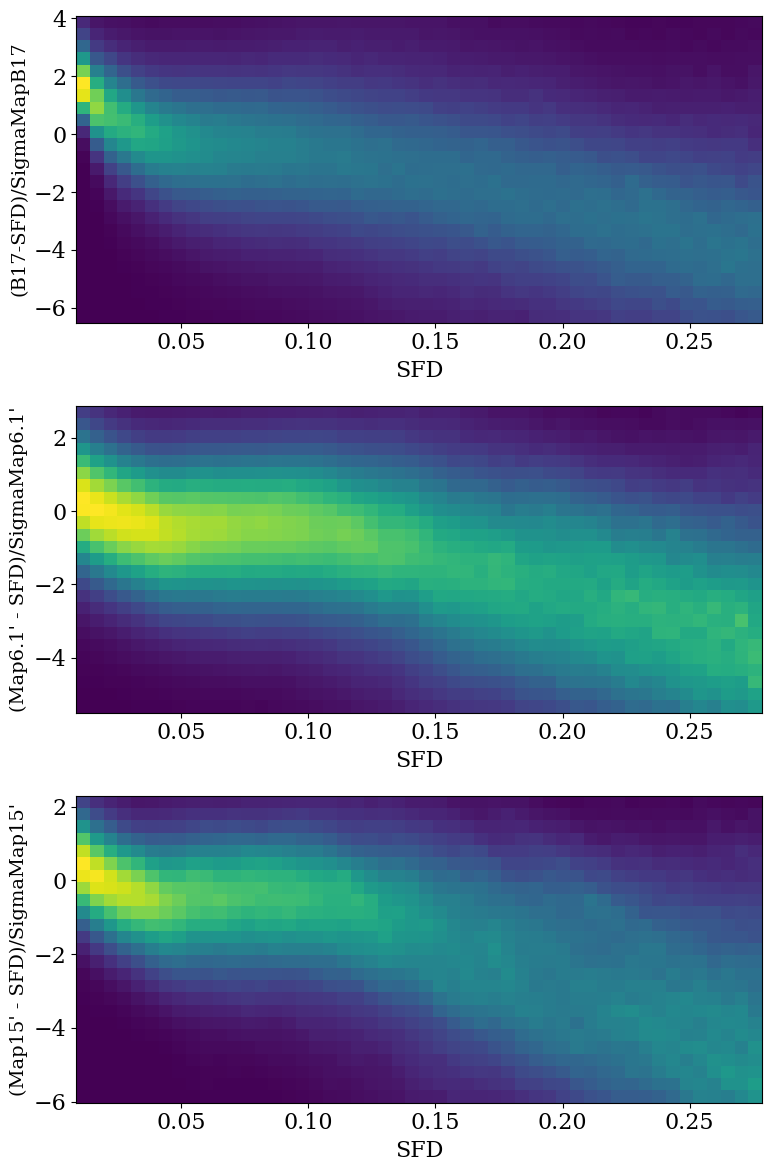

In [23]:
plt.rcParams.update({'figure.autolayout': True, 'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 12), nrows=3)
for i, hmap in enumerate(histmaps):
    ax[i].pcolormesh(xedg[i], yedg[i], hmap.T, shading='flat', rasterized=True)
plt.setp(ax, xlabel='SFD')
ax[0].set_ylabel('(B17-SFD)/SigmaMapB17', fontsize=14)
ax[1].set_ylabel('(Map6.1\' - SFD)/SigmaMap6.1\'', fontsize=14)
ax[2].set_ylabel('(Map15\' - SFD)/SigmaMap15\'', fontsize=14)
plt.savefig('../plots/vs_extinction/11-17_zhogg_zptcorr_sigmacorr_raster.pdf', dpi=100)
plt.show()

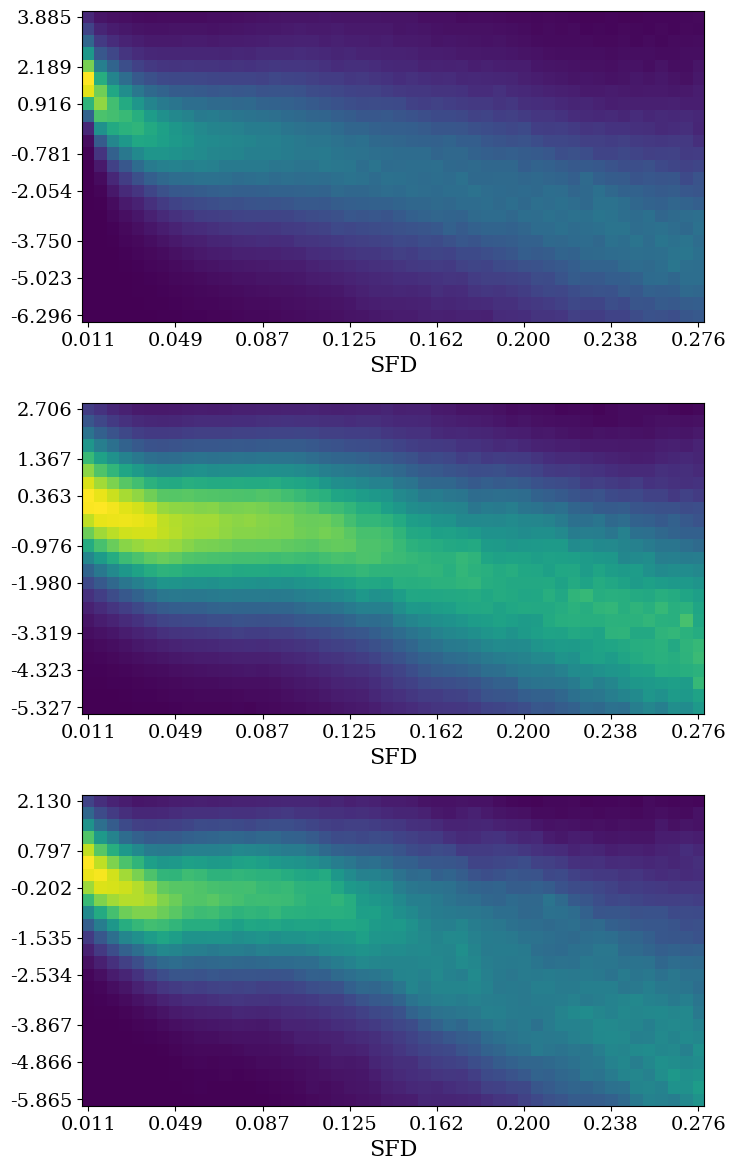

In [24]:
fig, ax = plt.subplots(figsize=(8, 12), nrows=3)
labelsx = np.linspace(0, Nbinx-1, 8, dtype=int)
labelsy = np.linspace(0, Nbiny-1, 8, dtype=int)
for i, hmap in enumerate(histmaps):
    ax[i].imshow(hmap.T, origin='lower')
    xt = (xedg[i][1:] + xedg[i][:-1])/2 
    yt = (yedg[i][1:] + yedg[i][:-1])/2 
    ax[i].set_xticks(labelsx, ['{:.3f}'.format(x) for x in xt[labelsx]], fontsize=14)
    ax[i].set_yticks(labelsy, ['{:.3f}'.format(x) for x in yt[labelsy]], fontsize=14)
plt.setp(ax, xlabel='SFD')

#plt.savefig('../plots/vs_extinction/11-10_zhogg_zptcorr_sigmacorr.pdf', dpi=100)
plt.show()

<ipython-input-16-ddc840ddfb10>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../plots/vs_extinction/sfdvals_fullr.png', dpi=100, layout='tight')


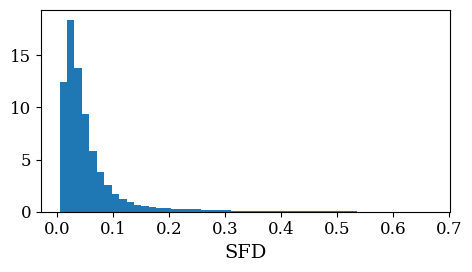

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.hist(sfdvals, bins=50, range=[np.percentile(sfdvals, 0.01), np.percentile(sfdvals, 99.9)], density=True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('SFD', fontsize=14)
plt.savefig('../plots/vs_extinction/sfdvals_fullr.png', dpi=100, layout='tight')
plt.show()

## Figure 8

In [3]:
from functools import partial

In [4]:
sfdmap = vis_utils.get_sfd_map()
b17map, b17sigmamap = get_bayestar2017_map(return_sigma=True)
fskdir = '../notebooks_main1/fullsky_runs/'

fits61 = hp.fitsfunc.read_map(fskdir+'fits_outputs/recon_fw6-1_final_mult.fits', field=None, h=True)
fits15 = hp.fitsfunc.read_map(fskdir+'fits_outputs/recon_fw15_final_mult.fits', field=None, h=True)

reconzpt61, var61_corr = fits61[0][1], fits61[0][3]
reconzpt15, var15_corr = fits15[0][1], fits15[0][3]

sigmafw61 = np.sqrt(var61_corr)
sigmafw15 = np.sqrt(var15_corr)

Multiplying by the blue tip correction factor of 0.86
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)


<ipython-input-4-4863b3fbab04>:11: RuntimeWarning: invalid value encountered in sqrt
  sigmafw61 = np.sqrt(var61_corr)
<ipython-input-4-4863b3fbab04>:12: RuntimeWarning: invalid value encountered in sqrt
  sigmafw15 = np.sqrt(var15_corr)


In [5]:
compmaps = [('B17', b17map, b17sigmamap), ('FWHM=6.1\'', reconzpt61, sigmafw61), ('FWHM=15\'', reconzpt15, sigmafw15)]
mapcomp = MapComparisons(compmaps)

Multiplying by the blue tip correction factor of 0.86
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)


In [6]:
fptfile = '/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/fullsky_runs/footprints/ftp_minimal_7_4.pkl'

In [7]:
latrange = np.arange(30, 100, 10).astype('int')
latrange = np.insert(latrange, 0, 25)
latwise_offsets = []
for lat in latrange:
    patches = get_testbeds_latitudewise(lat, get_pixels_in_recon61xbayestar_footprint, 
                Numoutput='max', Nresol=2048, fargs={'picklefile': fptfile})
    latwise_offsets.append(mapcomp.get_sfd_offset_noise_for_patches(patches))

Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)
B17
Latitude~25 105
FWHM=6.1'
Latitude~25 105
FWHM=15'
Latitude~25 105
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)
B17
Latitude~30 114
FWHM=6.1'
Latitude~30 114
FWHM=15'
Latitude~30 114
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)
B17
Latitude~40 127
FWHM=6.1'
Latitude~40 127
FWHM=15'
Latitude~40 127
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)
B17
Latitude~50 108
FWHM=6.1'
Latitude~50 108
FWHM=15'
Latitude~50 108
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)
B17
Latitude~60 80
FWHM=6.1'
Latitude~60 80
FWHM=15'
Latitude~60 80
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)
B17
Latitude~70 56
FWHM=6.1'
Latitude~70 56
FWHM=15'
Latitude~70 56
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) 

This repeats that line because every call to footprint also reads in B17 and makes sure the pixels aint nans

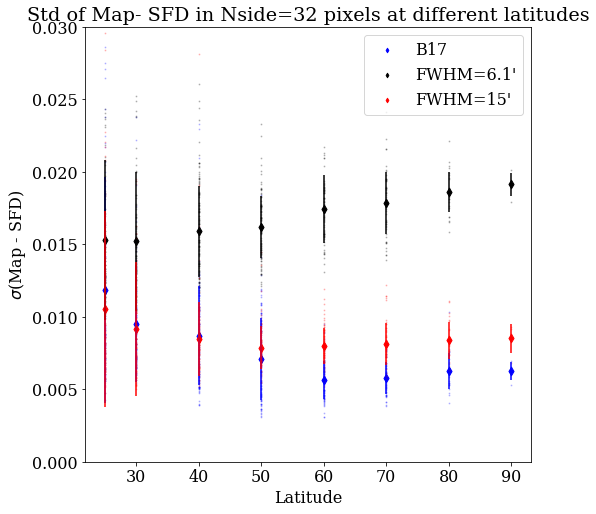

In [9]:
%matplotlib inline
#this was run with get_pixels_in_bayestar_footprint
plt.rcParams.update({'font.family':'serif', 'font.size': 16})
import importlib
importlib.reload(vis_utils)
vis_utils.plot_noise_vs_latitude(latwise_offsets, 
            {'figsize': (8, 8), 'dpi': 150, 'errorbars': True, 'ylim': [0, 0.03], 'savefig': 
             {'fname': '../plots/11-17_stdoff_v_lat.pdf', 'bbox_inches': 'tight'}})

## Figure 9

In [3]:
sfdmap = vis_utils.get_sfd_map()
b17map, b17sigmamap = get_bayestar2017_map(return_sigma=True)
fskdir = '../notebooks_main1/fullsky_runs/'

fits61 = hp.fitsfunc.read_map(fskdir+'fits_outputs/recon_fw6-1_final_mult.fits', field=None, h=True)
fits15 = hp.fitsfunc.read_map(fskdir+'fits_outputs/recon_fw15_final_mult.fits', field=None, h=True)

reconzpt61, var61_corr = fits61[0][1], fits61[0][3]
reconzpt15, var15_corr = fits15[0][1], fits15[0][3]

Multiplying by the blue tip correction factor of 0.86
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)


In [4]:
tgepath = '/n/holylfs05/LABS/finkbeiner_lab/Lab/nmudur/storage_misc/gaia_tge_pix2k.fits'
tgemap = hp.read_map(tgepath, field=None,h=True)

In [5]:
fptpixels = np.arange(hp.nside2npix(2048))
fptpixels = fptpixels[reconzpt61!=hp.UNSEEN]

In [6]:
goodpix = fptpixels
compmaps = [('B17', get_masked_patch(b17map,goodpix)),
            ('GaiaTGE', get_masked_patch(tgemap[0]/3.1, goodpix)), 
             ('FWHM=6.1\'', get_masked_patch(reconzpt61, goodpix)), 
              ('FWHM=15\'', get_masked_patch(reconzpt15, goodpix))]

In [7]:
mapcomp = MapComparisons(compmaps)
compmaps_vis = [('SFD', get_masked_patch(mapcomp.sfdmap, goodpix))] + compmaps

Multiplying by the blue tip correction factor of 0.86
Multiplying by the EBV conversion factor of 0.856 derived from E(g-r) relation (Eq1)


### get testbeds

In [8]:
testbedlist = []
for tname in ['Ursa Major']:
    testbedlist.append(get_testbed_dict(tname))

Nresol=2048
pix2k = get_tile_idx_in_circlepatch(Nresol, [8, 30], 2)
rot, xsize = [8, 30], 500
tdict = {'name':r'(l, b)=({}°, {}°)'.format(rot[0], rot[1]), 'coords': pix2k, 'Nresol': Nresol, 'rot': rot, 'xsize': xsize}
testbedlist.append(tdict)

Nresol=2048
rot = [178, -50]
pix2k = get_tile_idx_in_circlepatch(Nresol, rot, 2)
xsize = 500
tdict = {'name':r'(l, b)=({}°, {}°)'.format(rot[0], rot[1]), 'coords': pix2k, 'Nresol': Nresol, 'rot': rot, 'xsize': xsize}
testbedlist.append(tdict)

Nresol=2048
rot = [360-158, -41]
pix2k = get_tile_idx_in_circlepatch(Nresol, rot, 2)
xsize = 500
tdict = {'name':r'(l, b)=({}°, {}°)'.format(rot[0], rot[1]), 'coords': pix2k, 'Nresol': Nresol, 'rot': rot, 'xsize': xsize}
testbedlist.append(tdict)

Nresol=2048
rot = [200, -35]
pix2k = get_tile_idx_in_circlepatch(Nresol, rot, 2)
xsize = 500
tdict = {'name':r'(l, b)=({}°, {}°)'.format(rot[0], rot[1]), 'coords': pix2k, 'Nresol': Nresol, 'rot': rot, 'xsize': xsize}
testbedlist.append(tdict)

Nresol=2048
rot = [0, 80]
pix2k = get_tile_idx_in_circlepatch(Nresol, rot, 2)
xsize = 500
tdict = {'name':r'(l, b)=({}°, {}°)'.format(rot[0], rot[1]), 'coords': pix2k, 'Nresol': Nresol, 'rot': rot, 'xsize': xsize}
testbedlist.append(tdict)

In [13]:
import importlib
importlib.reload(vis_utils)

<module 'vis_utils' from '/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/utils/vis_utils.py'>

/n/home02/nmudur/.conda/envs/pytorch_env2/lib/python3.8/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Color pegged to Map, Min, Max FWHM=6.1' -0.015510209950090786 0.16846146473124468
Color pegged to Map, Min, Max FWHM=6.1' 0.060769674586870916 0.4181286982898207
Color pegged to Map, Min, Max FWHM=6.1' -0.007166708045451761 0.16044788808790664
Color pegged to Map, Min, Max FWHM=6.1' -0.004108769091939927 0.1296738137703687
Color pegged to Map, Min, Max FWHM=6.1' -0.008359078321296752 0.17918240996559728
Color pegged to Map, Min, Max FWHM=6.1' -0.021806352582913305 0.08070962048781297


/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/utils/vis_utils.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if 'savefig' in kwargs_dict.keys():


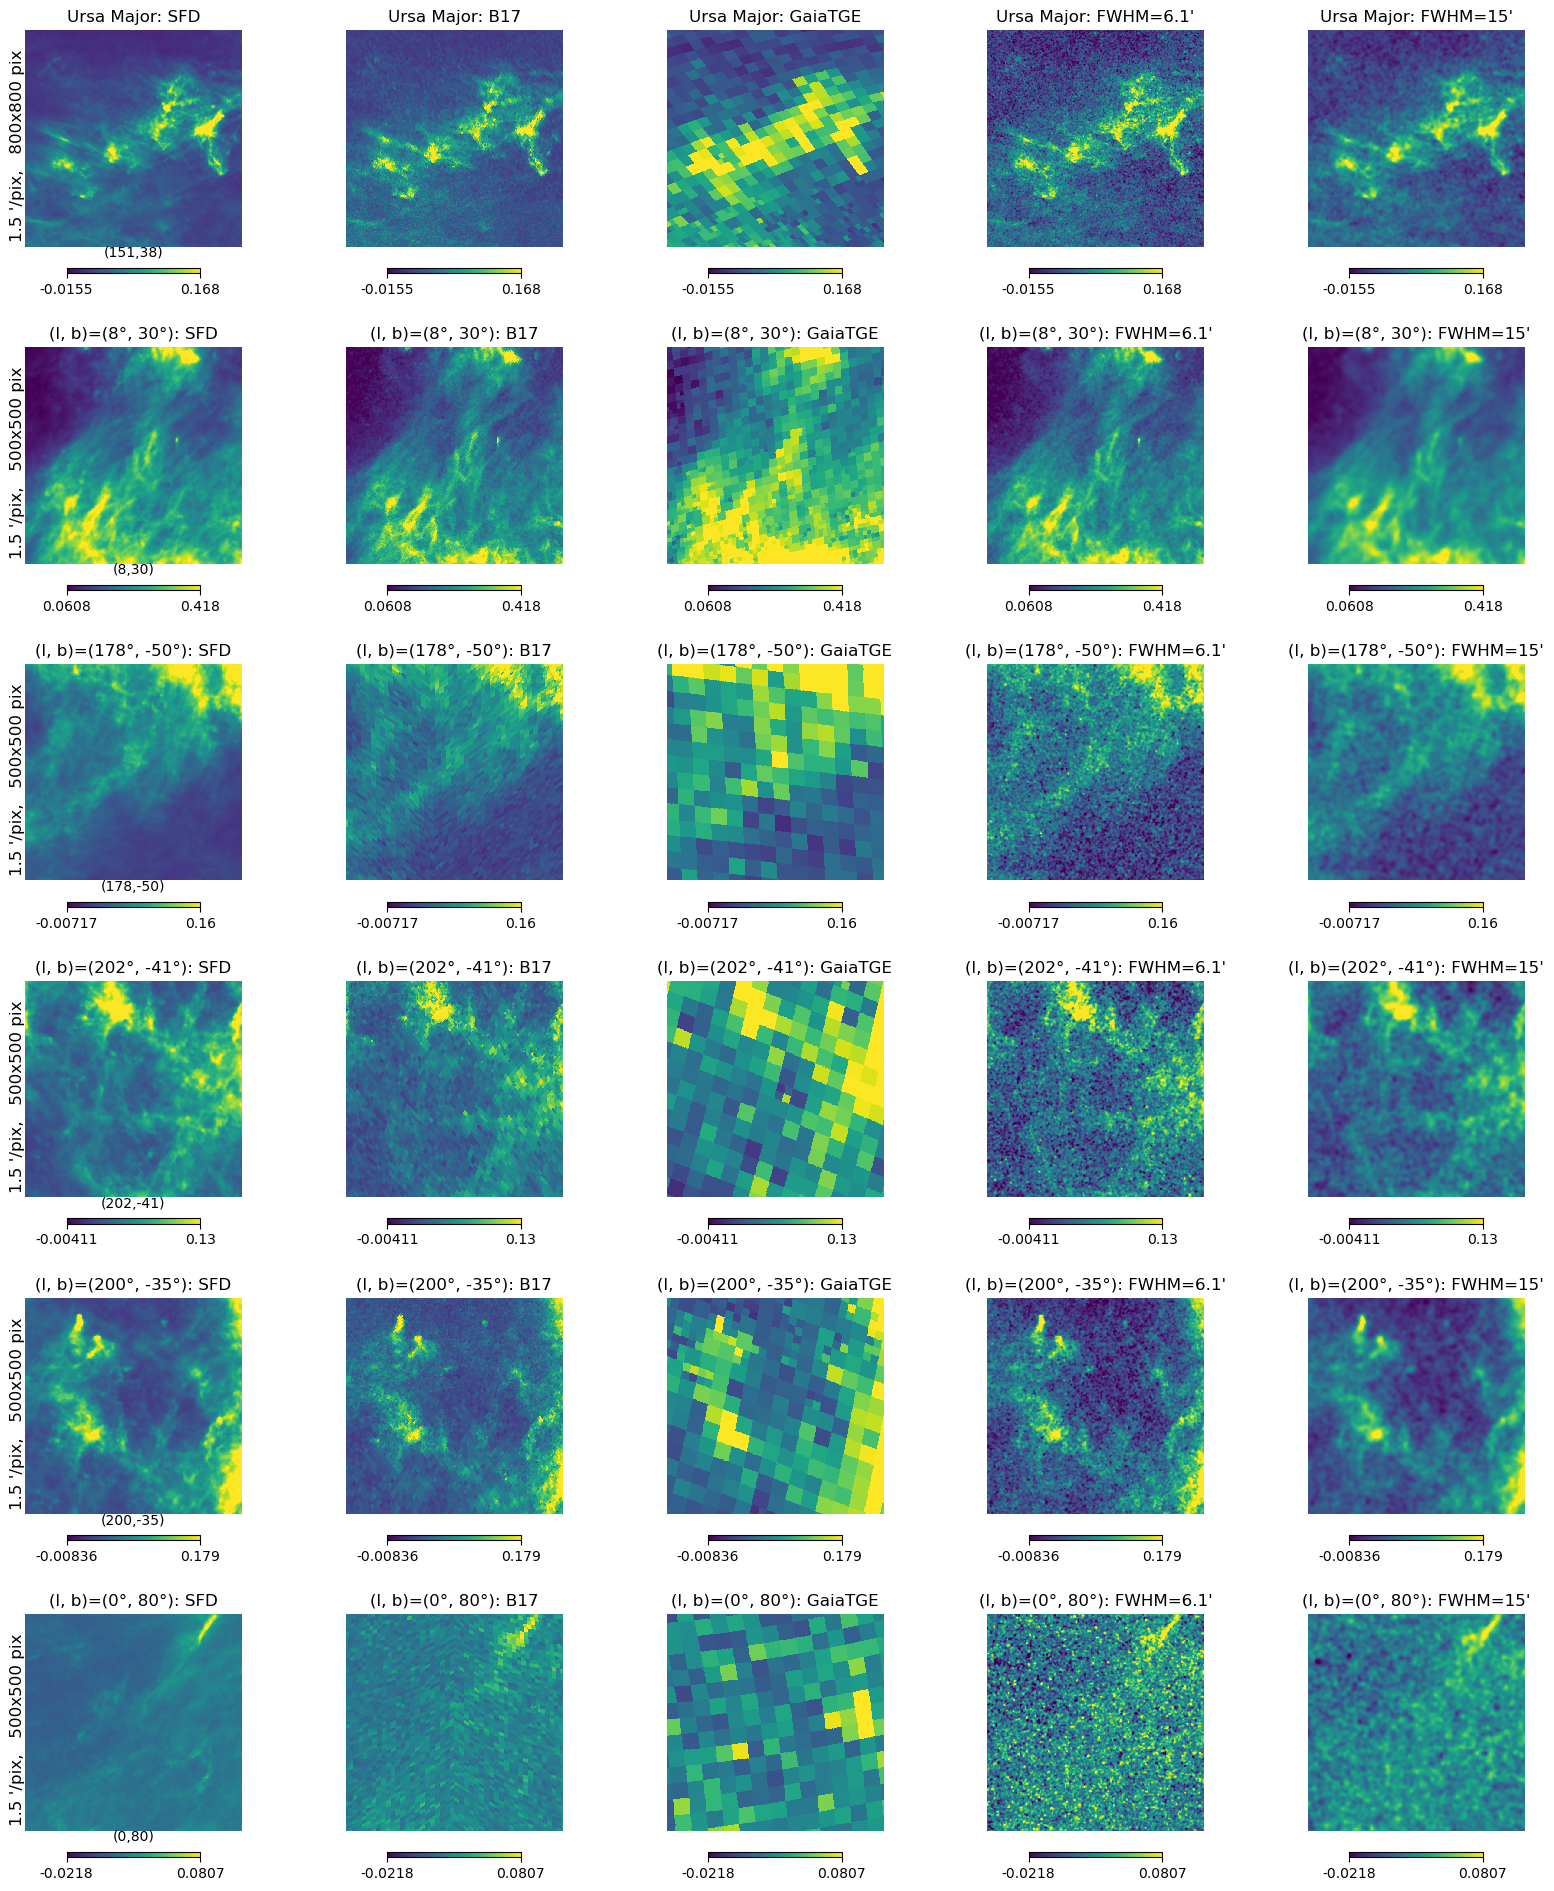

In [14]:
vis_utils.plot_maps_comparison(testbedlist, compmaps_vis, 
                               norm='minmax', figsize=(20, 24), 
            kwargs_dict={'norm_percs': [1, 99], 'peg_to_map_idx': -2, 
                         'savefig': '../plots/11-17_comp_panel_rerun_wtge_mm1_tile.pdf'})